# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

import tensorflow as tf

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision

# Importing Deep Learning Libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow import keras

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from keras.models import load_model

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Displaying Images

In [3]:
picture_size = 48
folder_path = "./dataset/"

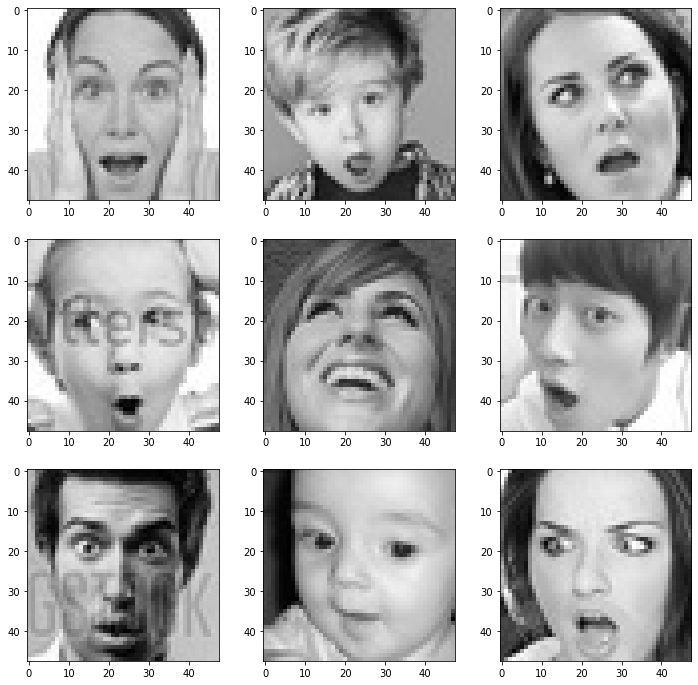

In [4]:
expression = 'surprise'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

# Making Training and Validation Data

In [5]:
batch_size  = 64

datagen_train  = ImageDataGenerator(rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))

# datagen_train  = ImageDataGenerator()

datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Model Building

In [6]:
def cnn():
    no_of_classes = 7
    model = Sequential()
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1)))    
    model.add(Dropout(0.25))
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same'))  
    model.add(Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.25))
    
    model.add(Conv2D(192, (3, 3), activation='relu', padding = 'same'))    
    model.add(Conv2D(192, (5, 5), activation='relu', padding = 'same'))
    model.add(Conv2D(192, (5, 5), activation='relu', padding = 'same', strides = 2))    
    model.add(Dropout(0.5))    
    
    model.add(Conv2D(192, (7, 7), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1),padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(10, (1, 1), padding='valid'))

    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(no_of_classes, activation='softmax'))
    opt = Adam(learning_rate = 0.0001)
    model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model

In [7]:
model = cnn()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 96)        960       
                                                                 
 dropout (Dropout)           (None, 48, 48, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 96)        83040     
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 96)        83040     
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 96)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 192)       166080    
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 192)       9

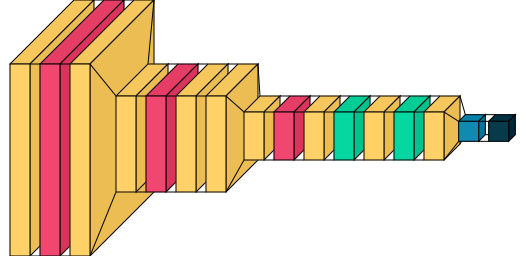

In [8]:
import visualkeras
visualkeras.layered_view(model)

# Fitting the Model with Training and Validation Data 

In [10]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model/model1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=25,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=20,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [checkpoint]

epochs = 150

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [11]:
history = model.fit(train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/150
448/448 [==============================] - ETA: 0s - loss: 1.8328 - accuracy: 0.2498
Epoch 1: val_accuracy improved from -inf to 0.24707, saving model to ./model\model1.h5
448/448 [==============================] - 76s 153ms/step - loss: 1.8328 - accuracy: 0.2498 - val_loss: 1.8293 - val_accuracy: 0.2471
Epoch 2/150
448/448 [==============================] - ETA: 0s - loss: 1.8162 - accuracy: 0.2543
Epoch 2: val_accuracy improved from 0.24707 to 0.24930, saving model to ./model\model1.h5
448/448 [==============================] - 70s 155ms/step - loss: 1.8162 - accuracy: 0.2543 - val_loss: 1.8179 - val_accuracy: 0.2493
Epoch 3/150
448/448 [==============================] - ETA: 0s - loss: 1.8028 - accuracy: 0.2558
Epoch 3: val_accuracy improved from 0.24930 to 0.25739, saving model to ./model\model1.h5
448/448 [==============================] - 71s 158ms/step - loss: 1.8028 - accuracy: 0.2558 - val_loss: 1.7828 - val_accuracy: 0.2574
Epoch 4/150
448/448 [===================

448/448 [==============================] - ETA: 0s - loss: 1.0517 - accuracy: 0.6105
Epoch 27: val_accuracy did not improve from 0.62695
448/448 [==============================] - 71s 159ms/step - loss: 1.0517 - accuracy: 0.6105 - val_loss: 1.0064 - val_accuracy: 0.6246
Epoch 28/150
448/448 [==============================] - ETA: 0s - loss: 1.0398 - accuracy: 0.6148
Epoch 28: val_accuracy did not improve from 0.62695
448/448 [==============================] - 71s 159ms/step - loss: 1.0398 - accuracy: 0.6148 - val_loss: 1.0346 - val_accuracy: 0.6159
Epoch 29/150
448/448 [==============================] - ETA: 0s - loss: 1.0379 - accuracy: 0.6146
Epoch 29: val_accuracy improved from 0.62695 to 0.63407, saving model to ./model\model1.h5
448/448 [==============================] - 71s 159ms/step - loss: 1.0379 - accuracy: 0.6146 - val_loss: 0.9833 - val_accuracy: 0.6341
Epoch 30/150
448/448 [==============================] - ETA: 0s - loss: 1.0260 - accuracy: 0.6171
Epoch 30: val_accuracy d

Epoch 55/150
448/448 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.6789
Epoch 55: val_accuracy did not improve from 0.66071
448/448 [==============================] - 71s 159ms/step - loss: 0.8767 - accuracy: 0.6789 - val_loss: 0.9871 - val_accuracy: 0.6491
Epoch 56/150
448/448 [==============================] - ETA: 0s - loss: 0.8654 - accuracy: 0.6851
Epoch 56: val_accuracy did not improve from 0.66071
448/448 [==============================] - 71s 159ms/step - loss: 0.8654 - accuracy: 0.6851 - val_loss: 0.9523 - val_accuracy: 0.6451
Epoch 57/150
448/448 [==============================] - ETA: 0s - loss: 0.8674 - accuracy: 0.6797
Epoch 57: val_accuracy improved from 0.66071 to 0.66588, saving model to ./model\model1.h5
448/448 [==============================] - 71s 159ms/step - loss: 0.8674 - accuracy: 0.6797 - val_loss: 0.9547 - val_accuracy: 0.6659
Epoch 58/150
448/448 [==============================] - ETA: 0s - loss: 0.8595 - accuracy: 0.6832
Epoch 58: v

Epoch 112/150
448/448 [==============================] - ETA: 0s - loss: 0.6688 - accuracy: 0.7526
Epoch 112: val_accuracy did not improve from 0.67997
448/448 [==============================] - 71s 159ms/step - loss: 0.6688 - accuracy: 0.7526 - val_loss: 1.0474 - val_accuracy: 0.6702
Epoch 113/150
448/448 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.7551
Epoch 113: val_accuracy did not improve from 0.67997
448/448 [==============================] - 72s 160ms/step - loss: 0.6692 - accuracy: 0.7551 - val_loss: 1.0725 - val_accuracy: 0.6719
Epoch 114/150
448/448 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.7581
Epoch 114: val_accuracy did not improve from 0.67997
448/448 [==============================] - 72s 160ms/step - loss: 0.6565 - accuracy: 0.7581 - val_loss: 1.0362 - val_accuracy: 0.6670
Epoch 115/150
448/448 [==============================] - ETA: 0s - loss: 0.6620 - accuracy: 0.7571
Epoch 115: val_accuracy did not improve fro

Epoch 141/150
448/448 [==============================] - ETA: 0s - loss: 0.5976 - accuracy: 0.7840
Epoch 141: val_accuracy did not improve from 0.67997
448/448 [==============================] - 72s 161ms/step - loss: 0.5976 - accuracy: 0.7840 - val_loss: 1.1019 - val_accuracy: 0.6606
Epoch 142/150
448/448 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.7827
Epoch 142: val_accuracy did not improve from 0.67997
448/448 [==============================] - 72s 160ms/step - loss: 0.6015 - accuracy: 0.7827 - val_loss: 1.0756 - val_accuracy: 0.6674
Epoch 143/150
448/448 [==============================] - ETA: 0s - loss: 0.5938 - accuracy: 0.7825
Epoch 143: val_accuracy did not improve from 0.67997
448/448 [==============================] - 72s 161ms/step - loss: 0.5938 - accuracy: 0.7825 - val_loss: 1.0850 - val_accuracy: 0.6681
Epoch 144/150
448/448 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.7833
Epoch 144: val_accuracy did not improve fro

In [12]:
model_json = model.to_json()
with open("./model/model1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./model/model1.h5")
print("Saved model to disk")

Saved model to disk


# Plotting Accuracy & Loss

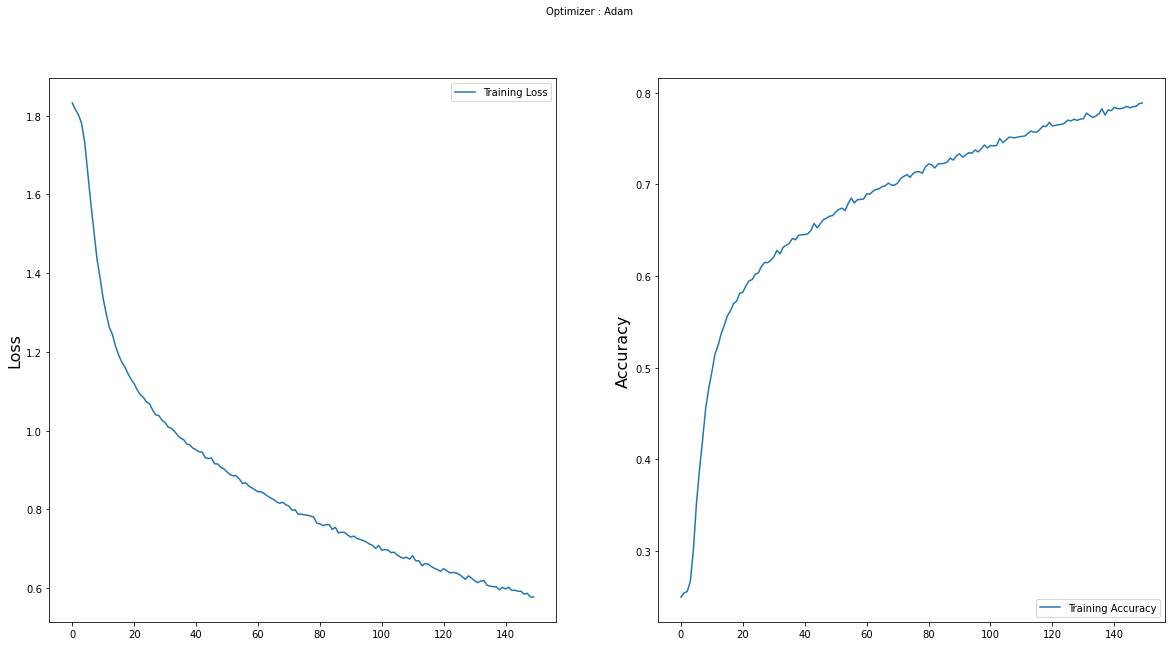

In [15]:
# plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
Y_pred = model.predict(test_set, 7178 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['angry', 'disgust', 'fear','happy','neutral','sad','surprise']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

113/113 [==============================] - 5s 45ms/step
Confusion Matrix
[[135  15 100 268 197 144  99]
 [ 19   3   8  26  24  26   5]
 [179  13 101 275 205 137 114]
 [308  26 195 451 342 247 205]
 [201  11 123 327 268 160 143]
 [202  11 123 318 245 190 158]
 [120  13  81 229 168 127  93]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.14      0.13       958
     disgust       0.03      0.03      0.03       111
        fear       0.14      0.10      0.12      1024
       happy       0.24      0.25      0.25      1774
     neutral       0.18      0.22      0.20      1233
         sad       0.18      0.15      0.17      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178

